# Final Model

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn import metrics
import re
import ast
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [ ]:
df_train_with_text = pd.read_csv("train_data_cleaned.csv",lineterminator='\n')
df_test_with_text = pd.read_csv("test_data_cleaned.csv",lineterminator='\n')

df_train_with_text['text_cleaned'] =df_train_with_text['text_cleaned'].astype(str)
df_test_with_text['text_cleaned'] =df_test_with_text['text_cleaned'].astype(str)


df_train_with_text.shape, df_test_with_text.shape

((174241, 18), (43560, 18))

In [ ]:
#prepare data
X = df_train_with_text
y = df_train_with_text['hindex']

# test my model
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.04, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

#train data
num_columns_to_use = ['degree','core_number','author_total_papers','average_neigbour_degree','cluster_of_node','std_neigh_index','mean_neigh_index','max_neigh_index']
numerical_train_data = X_train[num_columns_to_use].values
textual_train_data = X_train['text_cleaned'].values
y_train = y_train.values

#valid data
numerical_val_data = X_val[num_columns_to_use].values
textual_val_data = X_val['text_cleaned'].values
y_valid = y_val.values

#test data
numerical_test_data = df_test_with_text[num_columns_to_use].values
textual_test_data = df_test_with_text['text_cleaned'].values

print(numerical_train_data.shape, textual_train_data.shape, y_train.shape)
print(numerical_val_data.shape, textual_val_data.shape, y_valid.shape)
print(numerical_test_data.shape, textual_test_data.shape)

(167271, 18) (167271,) (6970, 18) (6970,)
(167271, 8) (167271,) (167271,)
(6970, 8) (6970,) (6970,)
(43560, 8) (43560,)


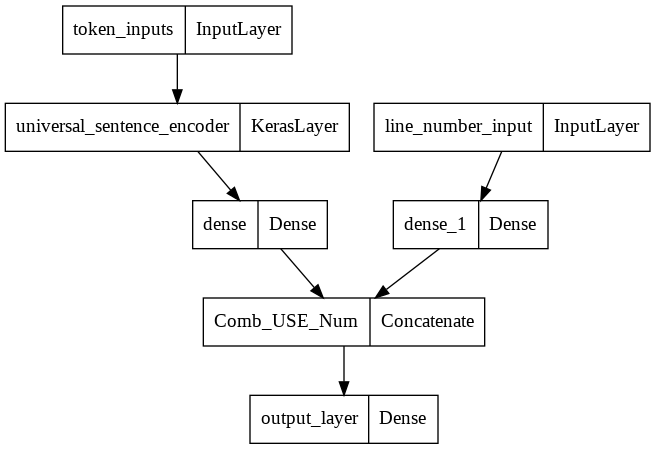

In [ ]:
# USE + numbers
import tensorflow_hub as hub
USE_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=True, name="universal_sentence_encoder")

# 1. USE
input_USE = layers.Input(shape=[], dtype=tf.string,name="token_inputs")
use_layer = USE_layer(input_USE)
outputs_USE = layers.Dense(64,activation="relu",kernel_regularizer='l1_l2',)(use_layer)

model_USE = tf.keras.Model(inputs=input_USE,
                             outputs=outputs_USE)

# 2. Numbers
number_inputs = layers.Input(shape=(8,), dtype=tf.int32, name="line_number_input")
number_outputs = layers.Dense(36, activation="relu", kernel_regularizer='l1_l2',)(number_inputs)
model_Num = tf.keras.Model(inputs=number_inputs,
                                   outputs=number_outputs)

combined_USE_Num = layers.Concatenate(name="Comb_USE_Num")([model_USE.output, model_Num.output])
final_output = layers.Dense(1, name="output_layer")(combined_USE_Num)

model_USE_Num = tf.keras.Model(inputs=[model_USE.input,
                                    model_Num.input
                                 ],
                         outputs=final_output)
from tensorflow.keras.utils import plot_model
plot_model(model_USE_Num)

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.92,
    staircase=True)

model_USE_Num.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss="mse",
                metrics=["mse"])

# train
train_dataset_data = tf.data.Dataset.from_tensor_slices((textual_train_data, numerical_train_data)) 
train_dataset_labels = tf.data.Dataset.from_tensor_slices(y_train) 
train_dataset_data_ziped = tf.data.Dataset.zip((train_dataset_data, train_dataset_labels))
train_dataset_FULL = train_dataset_data_ziped.batch(64).prefetch(tf.data.AUTOTUNE)

# valid
valid_dataset_data = tf.data.Dataset.from_tensor_slices((textual_val_data, numerical_val_data ))
valid_dataset_labels = tf.data.Dataset.from_tensor_slices(y_valid)
valid_dataset_data_ziped = tf.data.Dataset.zip((valid_dataset_data, valid_dataset_labels)) 
valid_dataset_FULL = valid_dataset_data_ziped.batch(64).prefetch(tf.data.AUTOTUNE)

# test
test_dataset_data = tf.data.Dataset.from_tensor_slices((textual_test_data, numerical_test_data )) 
test_dataset_labels = tf.data.Dataset.from_tensor_slices(np.zeros(len(df_test_with_text))) 
test_dataset_data_ziped = tf.data.Dataset.zip((test_dataset_data, test_dataset_labels)) 
test_dataset_FULL = test_dataset_data_ziped.batch(64).prefetch(tf.data.AUTOTUNE) 

print(len(train_dataset_FULL), len(valid_dataset_FULL), len(test_dataset_FULL))


model_USE_Num.fit(train_dataset_FULL,
            epochs=30,
            validation_data = valid_dataset_FULL,
                    callbacks=[
                                   create_model_checkpoint(model_name="comb"),
                                   early_callback,
                                   #reduce_lr
                                  ]
            )

2587 137 681
Epoch 1/20
2587/2587 [==============================] - ETA: 0s - loss: 69.0055 - mse: 61.2031INFO:tensorflow:Assets written to: model_experiments/comb/assets


INFO:tensorflow:Assets written to: model_experiments/comb/assets


2587/2587 [==============================] - 533s 203ms/step - loss: 69.0055 - mse: 61.2031 - val_loss: 57.7451 - val_mse: 52.3176
Epoch 2/20
2587/2587 [==============================] - ETA: 0s - loss: 33.5980 - mse: 27.7413INFO:tensorflow:Assets written to: model_experiments/comb/assets


INFO:tensorflow:Assets written to: model_experiments/comb/assets


2587/2587 [==============================] - 519s 201ms/step - loss: 33.5980 - mse: 27.7413 - val_loss: 53.7835 - val_mse: 48.4422
Epoch 3/20
2587/2587 [==============================] - ETA: 0s - loss: 22.7427 - mse: 17.2114INFO:tensorflow:Assets written to: model_experiments/comb/assets


INFO:tensorflow:Assets written to: model_experiments/comb/assets


2587/2587 [==============================] - 521s 201ms/step - loss: 22.7427 - mse: 17.2114 - val_loss: 52.7587 - val_mse: 47.7267
Epoch 4/20
2587/2587 [==============================] - 488s 189ms/step - loss: 19.3379 - mse: 14.0706 - val_loss: 53.6906 - val_mse: 48.8272
Epoch 5/20
2587/2587 [==============================] - ETA: 0s - loss: 17.2200 - mse: 12.2554INFO:tensorflow:Assets written to: model_experiments/comb/assets


INFO:tensorflow:Assets written to: model_experiments/comb/assets


2587/2587 [==============================] - 513s 198ms/step - loss: 17.2200 - mse: 12.2554 - val_loss: 51.5430 - val_mse: 46.9689
Epoch 6/20
2587/2587 [==============================] - 488s 189ms/step - loss: 15.0645 - mse: 10.2822 - val_loss: 51.9835 - val_mse: 47.6441
Epoch 7/20
2587/2587 [==============================] - 485s 188ms/step - loss: 13.9559 - mse: 9.3571 - val_loss: 54.0514 - val_mse: 49.6134
Epoch 8/20
2587/2587 [==============================] - 485s 188ms/step - loss: 12.7103 - mse: 8.2852 - val_loss: 56.8987 - val_mse: 52.3430
Epoch 9/20
2587/2587 [==============================] - 486s 188ms/step - loss: 11.4905 - mse: 7.2356 - val_loss: 52.0270 - val_mse: 47.7897
Epoch 10/20
2587/2587 [==============================] - 486s 188ms/step - loss: 10.4460 - mse: 6.4514 - val_loss: 52.3941 - val_mse: 48.4771


In [ ]:
model_USE_Num_loaded = tf.keras.models.load_model("model_experiments/comb")
model_USE_Num_loaded.evaluate(valid_dataset_FULL)

137/137 [==============================] - 17s 118ms/step - loss: 51.5430 - mse: 46.9689


[51.54302978515625, 46.96889877319336]

In [ ]:
pred = model_USE_Num_loaded.predict(test_dataset_FULL)
result = np.array([u[0] for u in pred])
result

array([ 6.2284627 ,  8.335105  , 22.59421   , ..., 48.855747  ,
       11.253104  ,  0.25114048], dtype=float32)

In [ ]:
df_test_with_text['hindex'] = pd.Series(np.round(result, decimals=3))

df_test_with_text.loc[:,["author","hindex"]].to_csv('our_submission.csv', index=False)